# Exploration Data Analysis
La idea del notebook es explorar en profundidad los datos usados para encontrar por ejemplo, la distacia promedio de las estaciones mas cercanas, el gap secundario o las estaciones usadas promedio y realizar unas visualizaciones al respecto

## Imports

In [0]:
import pandas as pd # data 
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import dask.dataframe as dd # read multiple csv to one dataframe
import numpy as np
import glob
sns.set(style="whitegrid", font_scale=1.4)
%matplotlib inline

## Load data
Se cargan los .csv y se concatenan para reunir toda la información de las distintas zonas en un solo dataframe

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_dir = '/content/drive/My Drive/key station analysis/Data Analysis/'

df = pd.concat([pd.read_csv(f, index_col=0, parse_dates=[1]) \
                for f in glob.glob(data_dir+'anali*.csv')])

#df.drop(['gap'], axis=1, inplace=True)
#df.rename({'fases_picadas':'fases_usadas'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, SGC2019gxzkd to SGC2020houiaz
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               105 non-null    datetime64[ns]
 1   gap                105 non-null    float64       
 2   gap_sec            105 non-null    float64       
 3   est_clave          105 non-null    object        
 4   est_cercana        105 non-null    object        
 5   dis_est_cercana    105 non-null    float64       
 6   est_cercana_2      105 non-null    object        
 7   dis_est_cercana_2  105 non-null    float64       
 8   est_picadas        105 non-null    float64       
 9   fases_usadas       105 non-null    int64         
 10  error_prof         105 non-null    float64       
 11  error_lat_lon      105 non-null    float64       
 12  gap_dif            105 non-null    float64       
 13  region             105 non-null    object        

## Data cleaning
Removing outliers

In [0]:
def remove_outliers(column_name, df):
  print(column_name)
  y = df[column_name]
  removed_outliers = y.between(y.quantile(.015), y.quantile(.985))
  index_names = df[~removed_outliers].index
  print(index_names)
  return index_names

del_depth_idx = remove_outliers('error_prof', df)
del_lat_lon_idx = remove_outliers('error_lat_lon', df)
try:
  df.drop(del_depth_idx, inplace=True)
  df.drop(del_lat_lon_idx, inplace=True)
except KeyError:
  pass
df.info()

error_prof
Index(['SGC2019qiyzb', 'SGC2018zengx', 'SGC2019okdkc', 'SGC2020aoyprh'], dtype='object')
error_lat_lon
Index(['SGC2018yyjft', 'SGC2018zengx', 'SGC2019okdkc'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, SGC2019gxzkd to SGC2020houiaz
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               101 non-null    datetime64[ns]
 1   gap                101 non-null    float64       
 2   gap_sec            101 non-null    float64       
 3   est_clave          101 non-null    object        
 4   est_cercana        101 non-null    object        
 5   dis_est_cercana    101 non-null    float64       
 6   est_cercana_2      101 non-null    object        
 7   dis_est_cercana_2  101 non-null    float64       
 8   est_picadas        101 non-null    float64       
 9   fases_usadas       101 non-null    int64         
 10  error_prof         101 non-n

Changing degrees for km


In [0]:
df['dis_est_cercana'] *= 111.32
df['dis_est_cercana_2'] *= 111.32

## Data exploration
### Region distribution

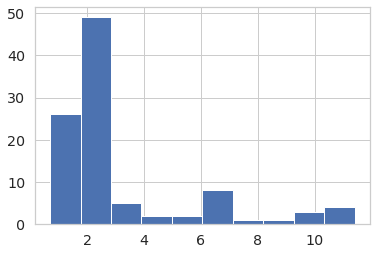

In [0]:
df.error_prof.hist()

Text(11.675000000000004, 0.5, 'Número de sismos')

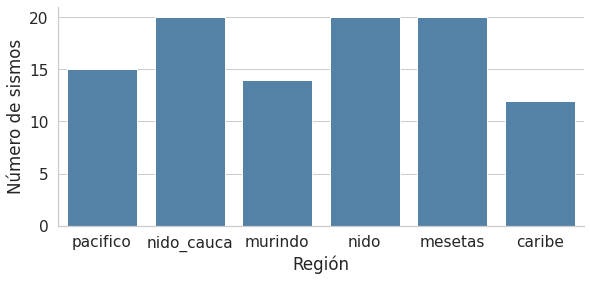

In [0]:
#sns.set_palette('Blues')
sns.catplot(x='region', kind='count', data=df, height=4, aspect=2, color='steelblue', sharex=False)
plt.xlabel('Región')
plt.ylabel('Número de sismos')

## Feature engieniering
Creating new columns associated with GT5_95 selection criteria:

* with an azimuthal gap of less than 110°
* with a secondary azimuthal gap of less than 160°
* with at least one station within 30 km from the epicentre
* with at least 10 stations, all within 250 km

In [0]:
df['satisfy_gap_crit'] = df['gap'] < 110
df['satisfy_sec_gap_crit'] = df['gap_sec'] < 160
df['satisfy_30km_crit'] = df['dis_est_cercana'] < 30
df[['gap','satisfy_gap_crit', 'gap_sec', 'satisfy_sec_gap_crit', 'dis_est_cercana', 'satisfy_30km_crit']].tail(3)

,gap,satisfy_gap_crit,gap_sec,satisfy_sec_gap_crit,dis_est_cercana,satisfy_30km_crit
SGC2019jjrcu,247.700975,False,256.306676,False,61.303026,False
SGC2019ofxms,225.691351,False,241.354533,False,76.698101,False
SGC2020houiaz,66.186568,True,100.836962,True,95.861105,False


### scatterplots

Text(0.5, 25.799999999999983, 'Región')

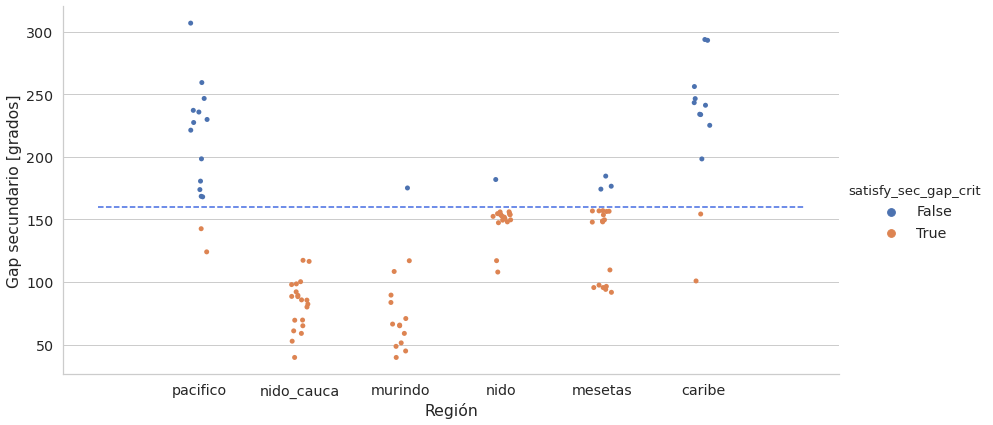

In [0]:
g = sns.catplot(x='region', y='gap_sec', data=df, height=6, aspect=2, hue='satisfy_sec_gap_crit')
plt.hlines(160, -1, 6, colors='royalblue', linestyle='dashed')
plt.ylabel('Gap secundario [grados]')
plt.xlabel('Región')

Text(0.5, 25.799999999999983, 'Región')

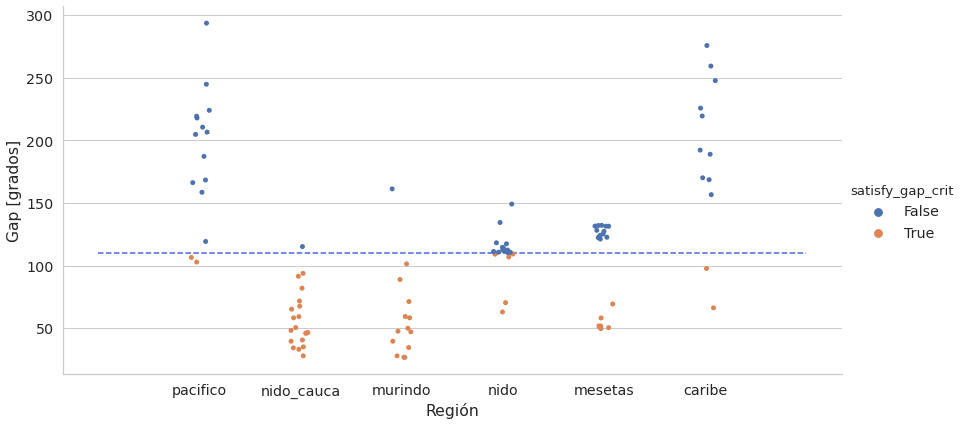

In [0]:
g = sns.catplot(x='region', y='gap', data=df, height=6, aspect=2, hue='satisfy_gap_crit')
plt.hlines(110, -1, 6, colors='royalblue', linestyle='dashed')
plt.ylabel('Gap [grados]')
plt.xlabel('Región')

Text(0.5, 25.799999999999983, 'Región')

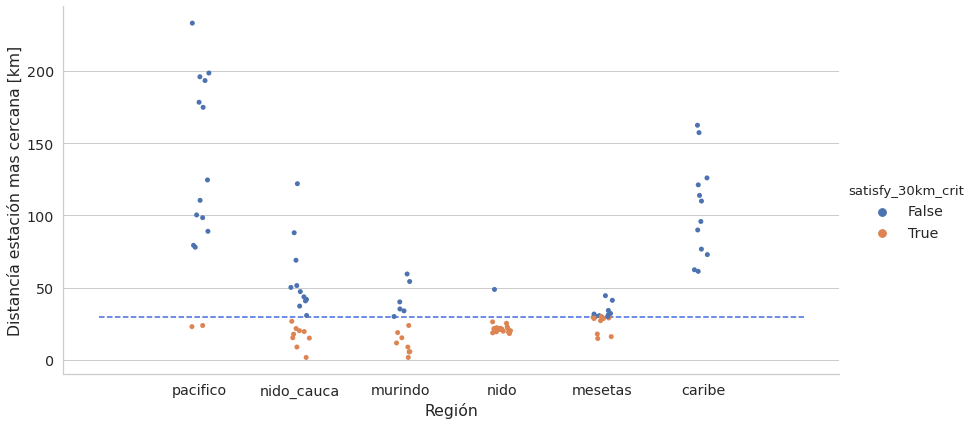

In [0]:
g = sns.catplot(x='region', y='dis_est_cercana', data=df, height=6, aspect=2, hue='satisfy_30km_crit')
plt.hlines(30, -1, 6, colors='royalblue', linestyle='dashed')
plt.ylabel('Distancía estación mas cercana [km]')
plt.xlabel('Región')

Creando nueva columna que combina los errores en profundidad y latlon

In [0]:
df['error_loc'] = np.sqrt(df['error_prof']**2 + 2*df['error_lat_lon']**2)
df['err_lat_lon'] = np.sqrt(2*df['error_lat_lon']**2)

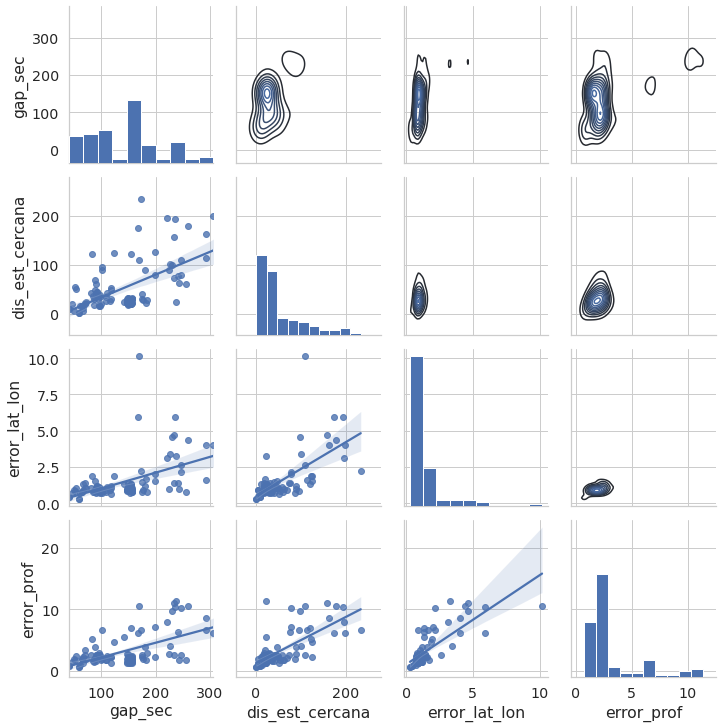

In [0]:
"""g = sns.pairplot(df, kind='reg',
             vars=['gap_sec', 'dis_est_cercana','error_lat_lon', 'error_prof'],
             #x_vars=['gap_sec', 'gap', 'dis_est_cercana'],
             #y_vars=['error_lat_lon', 'error_prof'],
             #height=5,
             #aspect=1
             corner=True
             )
g.fig.suptitle('Matriz de dispersión', size=20)"""
pairgrid = sns.PairGrid(data=df[['gap_sec', 'dis_est_cercana','error_lat_lon', 'error_prof']])
pairgrid = pairgrid.map_upper(sns.kdeplot)
pairgrid = pairgrid.map_diag(plt.hist)
pairgrid = pairgrid.map_lower(sns.regplot)

Text(0.5, 6.659375000000004, 'Región')

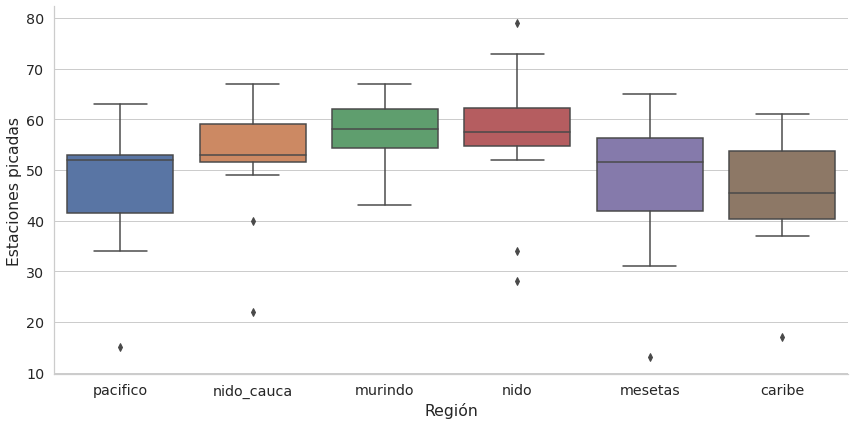

In [0]:
#sns.lmplot(x='gap_sec', y='error_prof', col='region', col_wrap=3, data=df)
grid = sns.catplot(x='region', y='est_picadas', #col_wrap=3,
                   data=df, kind='box', height=6, aspect=2)
plt.ylabel('Estaciones picadas')
plt.xlabel('Región')

Text(0.5, 6.659375000000004, 'Región')

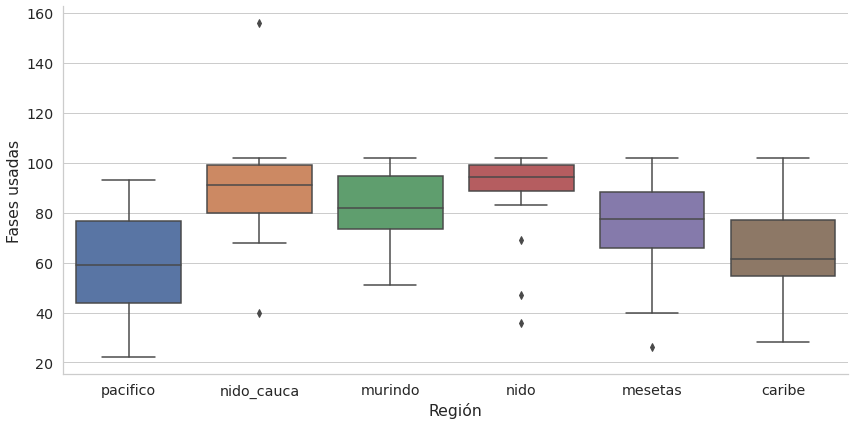

In [0]:
grid = sns.catplot(x='region', y='fases_usadas', #col_wrap=3,
                   data=df, kind='box', height=6, aspect=2)
plt.ylabel('Fases usadas')
plt.xlabel('Región')

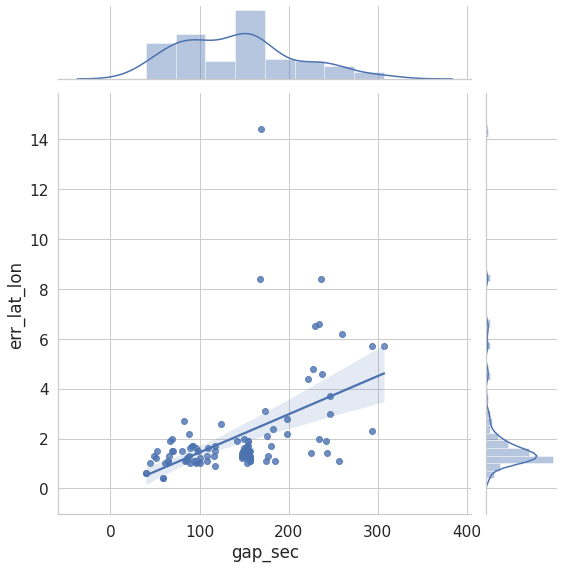

In [0]:
g = sns.jointplot(x='gap_sec', y='err_lat_lon', data=df, kind="reg", height=8)

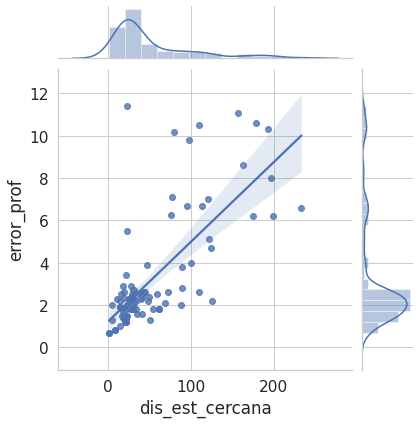

In [0]:
 sns.jointplot(x='dis_est_cercana', y='error_prof', data=df, kind="reg")

Text(0.5, 29.065624999999976, 'Distancia estación mas cercana [km]')

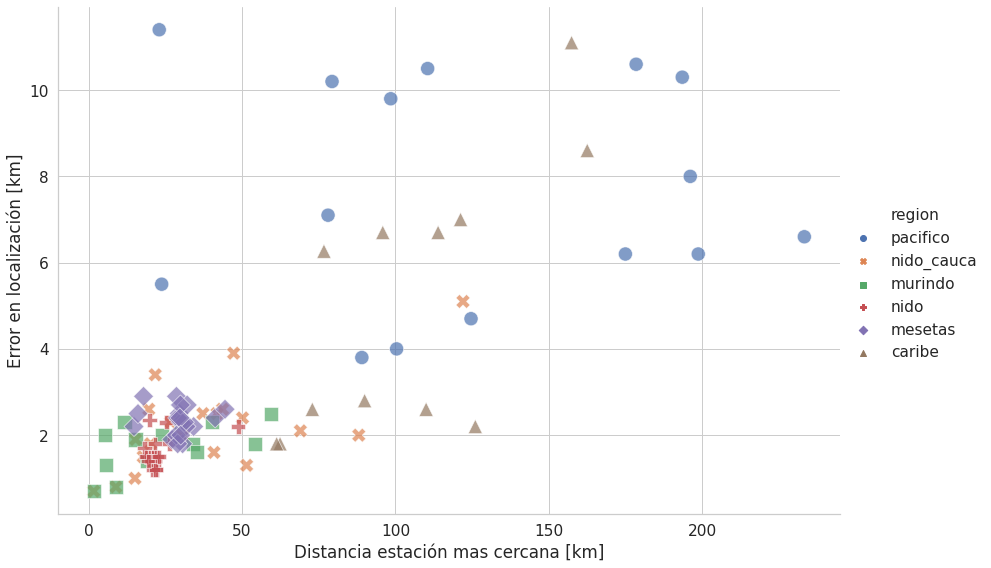

In [0]:
 sns.relplot(x='dis_est_cercana', y='error_prof',
             style='region', data=df, hue='region',
             height=8, aspect=1.5, s=200, alpha=0.7)
 plt.ylabel('Error en localización [km]')
plt.xlabel('Distancia estación mas cercana [km]')

Text(0.5, 28.800000000000004, 'GAP azimutal secundario [grad]')

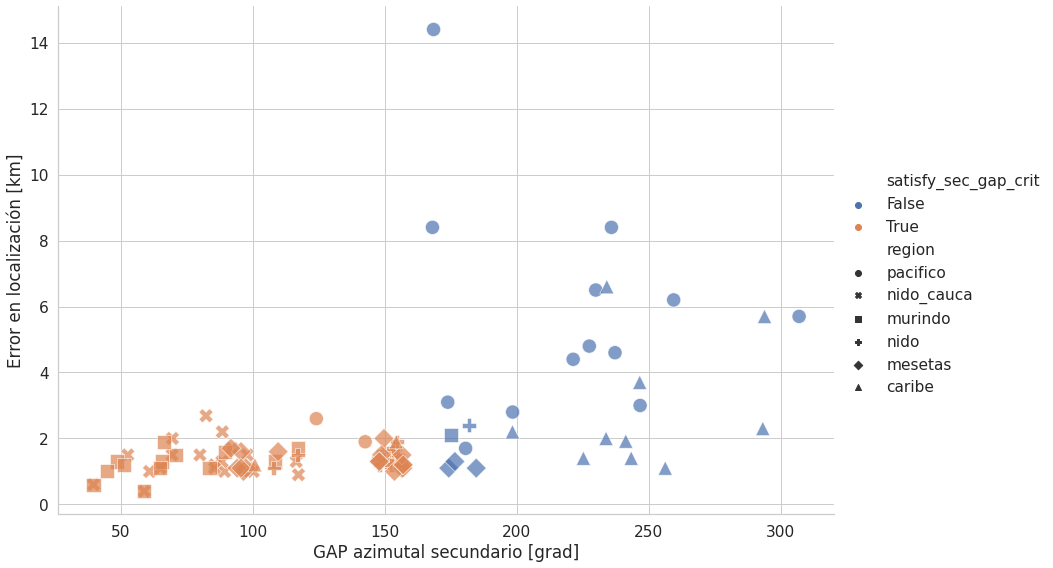

In [0]:
 sns.relplot(x='gap_sec', y='err_lat_lon',
             style='region', data=df, hue='satisfy_sec_gap_crit',
             height=8, aspect=1.5, s=200, alpha=0.7)
 plt.ylabel('Error en localización [km]')
plt.xlabel('GAP azimutal secundario [grad]')

## Estación mas cercana

In [0]:
df_1 = df[['region', 'est_cercana','dis_est_cercana']]
df_2 = df[['region', 'est_cercana_2','dis_est_cercana_2']]
df_2.rename(columns={'est_cercana_2':'est_cercana', 'dis_est_cercana_2':'dis_est_cercana'}, inplace=True)

df_ee = pd.concat([df_1, df_2])
df_ee = df_ee[df_ee.est_cercana != 'SDV']
df_ee = df_ee[df_ee.est_cercana != 'SNLR']
df_ee = df_ee[df_ee.est_cercana != 'TUM3C']

df_est = df_ee.groupby(['region', 'est_cercana'], sort=False)\
  .agg({'dis_est_cercana':['mean'], 'est_cercana':['count']})\
  .sort_values(['region', ('dis_est_cercana', 'mean')])

df_est.columns = df_est.columns.droplevel()
df_est.columns = ['Dist. promedio al sismo [km]', 'Frecuencia']
df_key_dis_1 = df_est.groupby(['region'], sort=False).head(5)
df_key_dis_1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Dist. promedio al sismo [km]  Frecuencia
region     est_cercana                                          
caribe     DRL05                           72.922554           1
           DRL06                           77.229793           1
           URI                             82.138042           1
           DRL01                           83.139725           1
           DRL02                           89.951173           1
mesetas    CLEJA                           16.294051           3
           URMC                            30.746117          18
           BET                             44.474745           1
           GARC                            81.036190           1
           PRA                             81.587116          16
murindo    PAL                             15.325757           1
           MAN1C                           17.529460           3
           DBB                             25.643096           3
           CBOC                            25.643096           4
           NIZA                            27.913578           3
nido       PDSC                            21.008863          17
           BAR2                            25.942988          18
           SPBC                            48.781983           1
           BRJC                            66.912453           2
           PAM                             74.625416           1
nido_cauca MAN1C                           10.617844           3
           NIZA                            20.835015           4
           PAL                             36.332489           7
           YOT                             47.725663          11
           RAC2C                           58.197808           1
pacifico   TUM                             89.851004           2
           GR1C                           111.086693           6
           PIZC                           113.941491           2
           MAL                            115.994942           1
           SOL                            149.751674           2

Text(34.82753433641976, 0.5, 'Distancia [km]')

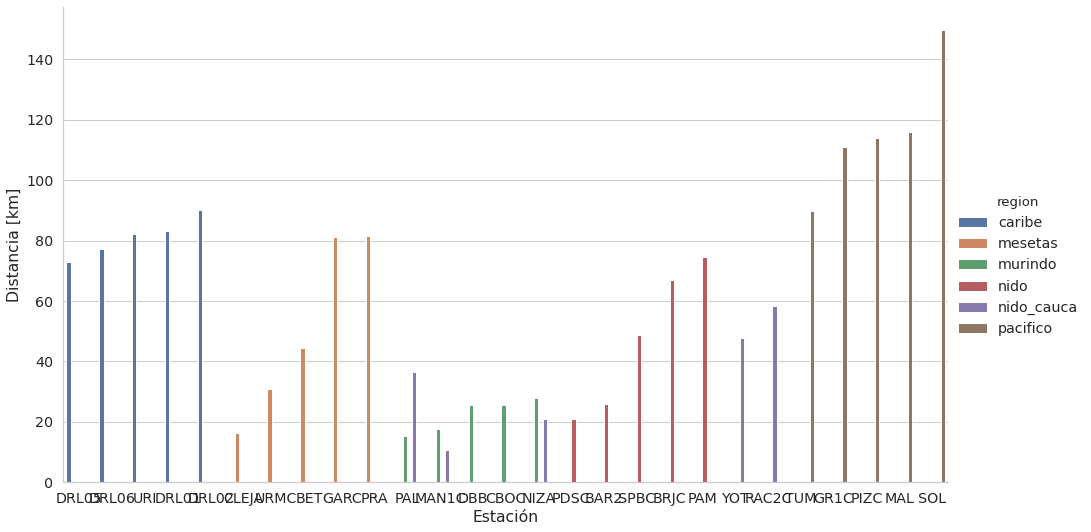

In [0]:
sns.catplot(x='est_cercana', y='Dist. promedio al sismo [km]', height=7.5, aspect=1.8,
            kind='bar', hue='region', data=df_key_dis_1.reset_index())
plt.xlabel('Estación')
plt.ylabel('Distancia [km]')

In [0]:
df_est['distancia ponderada [km]'] = df_est['Dist. promedio al sismo [km]']/df_est['Frecuencia']
df_key_dis = df_est[['distancia ponderada [km]', 'Frecuencia']]\
  .sort_values(['region', 'distancia ponderada [km]'])\
  .groupby(['region'], sort=False).head(3)
df_key_dis
#.style.set_table_styles([{'selector': 'tr:hover','props': [('background-color', 'yellow')]}])

#.style.background_gradient(cmap='Reds_r')

distancia ponderada [km]  Frecuencia
region     est_cercana                                      
caribe     CRJC                        24.180638           5
           ARGC                        28.979954           4
           SJC                         44.953327           3
mesetas    URMC                         1.708118          18
           PRA                          5.099195          16
           CLEJA                        5.431350           3
murindo    MAN1C                        5.843153           3
           CBOC                         6.410774           4
           DBB                          8.547699           3
nido       PDSC                         1.235815          17
           BAR2                         1.441277          18
           BRJC                        33.456227           2
nido_cauca MAN1C                        3.539281           3
           YOT                          4.338697          11
           PAL                          5.190356           7
pacifico   GR1C                        18.514449           6
           TUM                         44.925502           2
           PIZC                        56.970745           2

Text(33.592045010288075, 0.5, 'Distancia ponderada [km]')

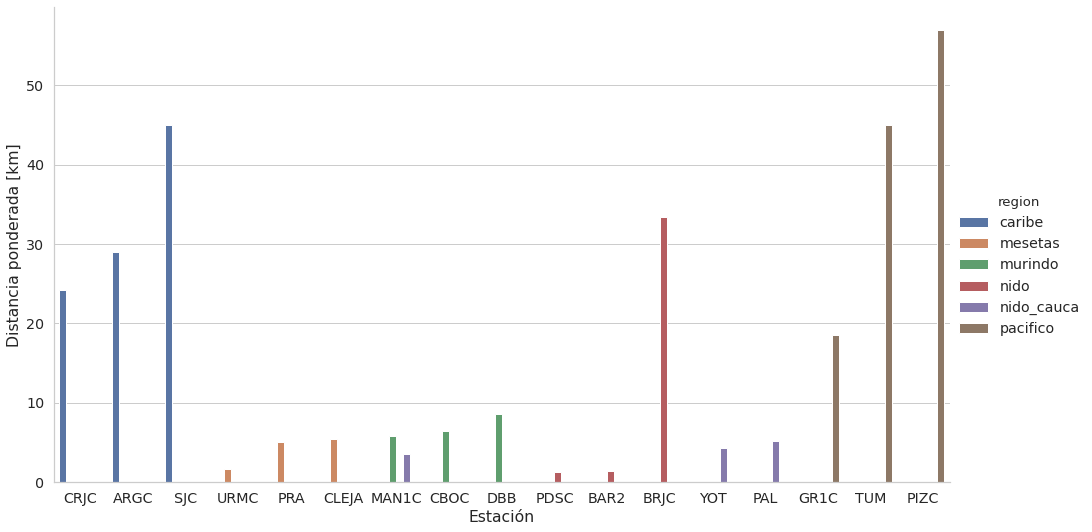

In [0]:
sns.catplot(x='est_cercana', y='distancia ponderada [km]', height=7.5, aspect=1.8,
            kind='bar', hue='region', data=df_key_dis.reset_index())
plt.xlabel('Estación')
plt.ylabel('Distancia ponderada [km]')

In [0]:
col_variable = 'Region'
hue_variable = 'sex'
row_variables = tips[row_variable].unique()
col_variables = tips[col_variable].unique()
num_rows = row_variables.shape[0]
num_cols = col_variables.shape[0]

fig,axes = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, figsize=(15,10))
subset = tips.groupby([row_variable,col_variable])
for row in range(num_rows):
    for col in range(num_cols):
        ax = axes[row][col]
        row_id = row_variables[row]
        col_id = col_variables[col]
        ax_data = subset.get_group((row_id, col_id))
        sns.scatterplot(x='total_bill', y='tip', data=ax_data, hue=hue_variable,ax=ax)
        title = row_variable + ' : '  + row_id + ' ' + col_variable + ' : ' + col_id
        ax.set_title(title)

NameError: ignored